In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap



In [2]:
load_from_scratch=True
plt.rcParams.update({
    # Use LaTeX default serif font-family.
    # https://matplotlib.org/stable/tutorials/text/usetex.html#sphx-glr-tutorials-text-usetex-py
     "font.family": "sans-serif",
     # Use specific cursive fonts.
     "font.cursive": ["Comic Neue", "Comic Sans MS"],
 })
font = {'fontname':'Comic Neue'}

In [3]:
def calculate_composite_rainfall():
    return 'hi'
    

In [4]:
# load current 1D dataset
real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')

# load ibtracks
tracks = pd.read_csv('/user/home/al18709/work/ibtracks/tc_files.csv')
og_tracks_grouped = tracks.groupby('sid')

# load original 2D WGAN
real_2,inputs_2,pred_2,meta_2,imput_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
real_og_x,_,_,_,_,_,pred_og_x,meta_og_x = load_tc_data(set='extreme_test',results='test')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')
# meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')

# load HighResMIP historical and ssp
hrmip_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/historical/storm_rain/storm_rain.npy')
hrmip_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/historical/storm_rain/storm_lats.npy')
hrmip_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/historical/storm_rain/storm_lons.npy')
hrmip_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/historical/storm_rain/storm_sid.csv')
print(hrmip_sids.sid.shape)
meta_hrmip_hist = pd.DataFrame({'sid':hrmip_sids.sid ,'centre_lat':hrmip_lats[:,4], 'centre_lon':hrmip_lons[:,4]})


(5236,)


In [5]:
print(real_og_x.shape)
print(pred_og_x.shape)
print(real.shape)
print(pred.shape)
print(pred_og.shape)

print(hrmip_rain)
print(hrmip_lats.shape)
print(hrmip_sids.sid.shape)
# print(hrmip_index.shape)




(5334, 100, 100)
(5334, 100, 100, 20)
(15930, 100, 100, 1)
(15930, 100, 100, 20)
(16253, 100, 100, 20)
[[[ 0.17411818  0.22538468  0.27644758 ...  0.38212107  0.27102871
    0.16021131]
  [ 0.1864161   0.259701    0.33277761 ...  0.24647564  0.20157695
    0.15696579]
  [ 0.19871196  0.29401142  0.38909804 ...  0.11085332  0.1321371
    0.15372081]
  ...
  [ 0.13363511  0.10123615  0.06944331 ... 10.16547204  8.87053155
    7.57468594]
  [ 0.21066548  0.15981065  0.10956236 ... 10.3303326   8.87721731
    7.42317347]
  [ 0.28770874  0.21839519  0.14968824 ... 10.49522123  8.88390421
    7.27163565]]

 [[ 5.44546936  4.8580716   4.26833387 ...  5.70292269  4.60991807
    3.51671549]
  [ 5.87046098  4.97067078  4.06858042 ...  5.64266482  4.58994931
    3.53704249]
  [ 6.29538148  5.08325064  3.86886099 ...  5.5824172   4.56998396
    3.5573661 ]
  ...
  [ 1.7897266   3.10281103  4.41091424 ... 15.18243664 19.21422501
   23.24944111]
  [ 1.4907506   2.2749717   3.05432122 ... 15.71322167

In [6]:
# load dataset
# load data
def generate_composite_rainfall(meta,rain,ibtracks=False,time_sample_rate=False):
	
	# get subset of storms
	sids = meta.sid
	sids_unique=sids.drop_duplicates()
	nstorms = len(sids_unique)
	tracks_grouped = meta.groupby('sid')
	composite_storm_rain = np.zeros((nstorms,100,100))
	i=0
	drop_idx=[]
	south_idx=[]
	north_idx=[]
	# find time frequency
	for sid in sids_unique:
		storm = tracks_grouped.get_group(sid)
		if ibtracks != False:
			storm_full = ibtracks.get_group(sid)
		else:
			storm_full = storm

		if time_sample_rate==False:
			
			hourly_rate=[]
			for h in storm_full.hour:
				if h in [3,9,15,21]:
					hour_rate = 3
				elif h in [0,6,12,18]:
					hour_rate = 6
				else:
					hour_rate = 0
				
				hourly_rate.append(hour_rate)

			# calculate hourly rates
			if set(hourly_rate) == {3,6}:
				# calculate storm duration as time rate (3 or 6 hourly time points) * number of time points
				storm_duration = 3 * len(storm) # this gives how many hours storm was alive for as a TC
				# define unit converstion as rain/storm_duration (number of hours) * 24 to get daily rain rate
				units_converter = 24/storm_duration

			elif 6 in set(hourly_rate): # so this means one datapoint every 6 hours
				storm_duration = 6 * len(storm) # this gives how many hours storm was alive for as a TC
				# need to multiply the rain by 2 because units are mm/3h, right now only accounting for half the rain, so multiplying by 2 is interpolating for rain between values
				units_converter = 24 * 2/storm_duration
			else:
				units_converter = 0
		else:
			
			storm_duration = time_sample_rate * len(storm)
			units_converter = 24 / storm_duration

		storm_lats = storm.centre_lat
		storm_lons = storm.centre_lon
		storm_rain = rain[storm.index,:,:,0]
		mean_storm_rain = np.sum(storm_rain,axis=0)*units_converter
		# storm_month = storm.month
		# storm_year = storm.year
		# storm_v = storm.v
		if units_converter == 0:
			drop_idx.append(i)
		else:
			if np.sum(storm_lats) < 0:
				south_idx.append(i)
			else:
				north_idx.append(i)
		

		composite_storm_rain[i,:,:] = mean_storm_rain
		i=i+1

	# save plottable dataset
	# composite_rainfall = calculate_composite_rainfall()
	# delete timestamps we can't use
	# np.delete(composite_storm_rain,drop_idx,axis=0)
	# get nh and sh datasets
	composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	print(composite_storm_rain.shape)
	print(composite_storm_rain_nh.shape)
	print(composite_storm_rain_sh.shape)
	composite_nh = np.mean(composite_storm_rain_nh,axis=0)
	composite_sh = np.mean(composite_storm_rain_sh,axis=0)
	return composite_nh,composite_sh




In [7]:
composite_nh,composite_sh = generate_composite_rainfall(meta,real,ibtracks=og_tracks_grouped)
composite_nh_x,composite_sh_x = generate_composite_rainfall(meta_og_x,np.expand_dims(real_og_x,axis=-1),ibtracks=og_tracks_grouped)
composite_wgan_nh,composite_wgan_sh = generate_composite_rainfall(meta,pred,ibtracks=og_tracks_grouped)
composite_og_nh,composite_og_sh = generate_composite_rainfall(meta_og,pred_og,ibtracks=og_tracks_grouped)
composite_og_x_nh,composite_og_x_sh = generate_composite_rainfall(meta_og_x,pred_og_x,ibtracks=og_tracks_grouped)
# print(composite_storm_rain.shape)
# sums_nh = np.sum(composite_storm_rain_nh,axis=(1,2))
# top_200_idx_nh = np.argpartition(sums_nh, -200)[-200:]
# sums_sh = np.sum(composite_storm_rain_sh,axis=(1,2))
# top_200_idx_sh = np.argpartition(sums_sh, -200)[-200:]

# top_200_storms_nh = composite_storm_rain[top_200_idx_nh,:,:]
# top_200_storms_sh = composite_storm_rain[top_200_idx_sh,:,:]

# composite_nh = np.mean(top_200_storms_nh,axis=0)
# composite_sh = np.mean(top_200_storms_sh,axis=0)
composite_hrmip_hist_nh,composite_hrmip_hist_sh = generate_composite_rainfall(meta_hrmip_hist,np.expand_dims(hrmip_rain,axis=-1),ibtracks=False,time_sample_rate=6)



(332, 100, 100)
(254, 100, 100)
(78, 100, 100)
(99, 100, 100)
(83, 100, 100)
(16, 100, 100)
(332, 100, 100)
(254, 100, 100)
(78, 100, 100)
(334, 100, 100)
(253, 100, 100)
(81, 100, 100)
(99, 100, 100)
(83, 100, 100)
(16, 100, 100)
(501, 100, 100)
(501, 100, 100)
(0, 100, 100)


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [8]:
# define cmap
precip_cmap,precip_norm = make_cmap()

/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


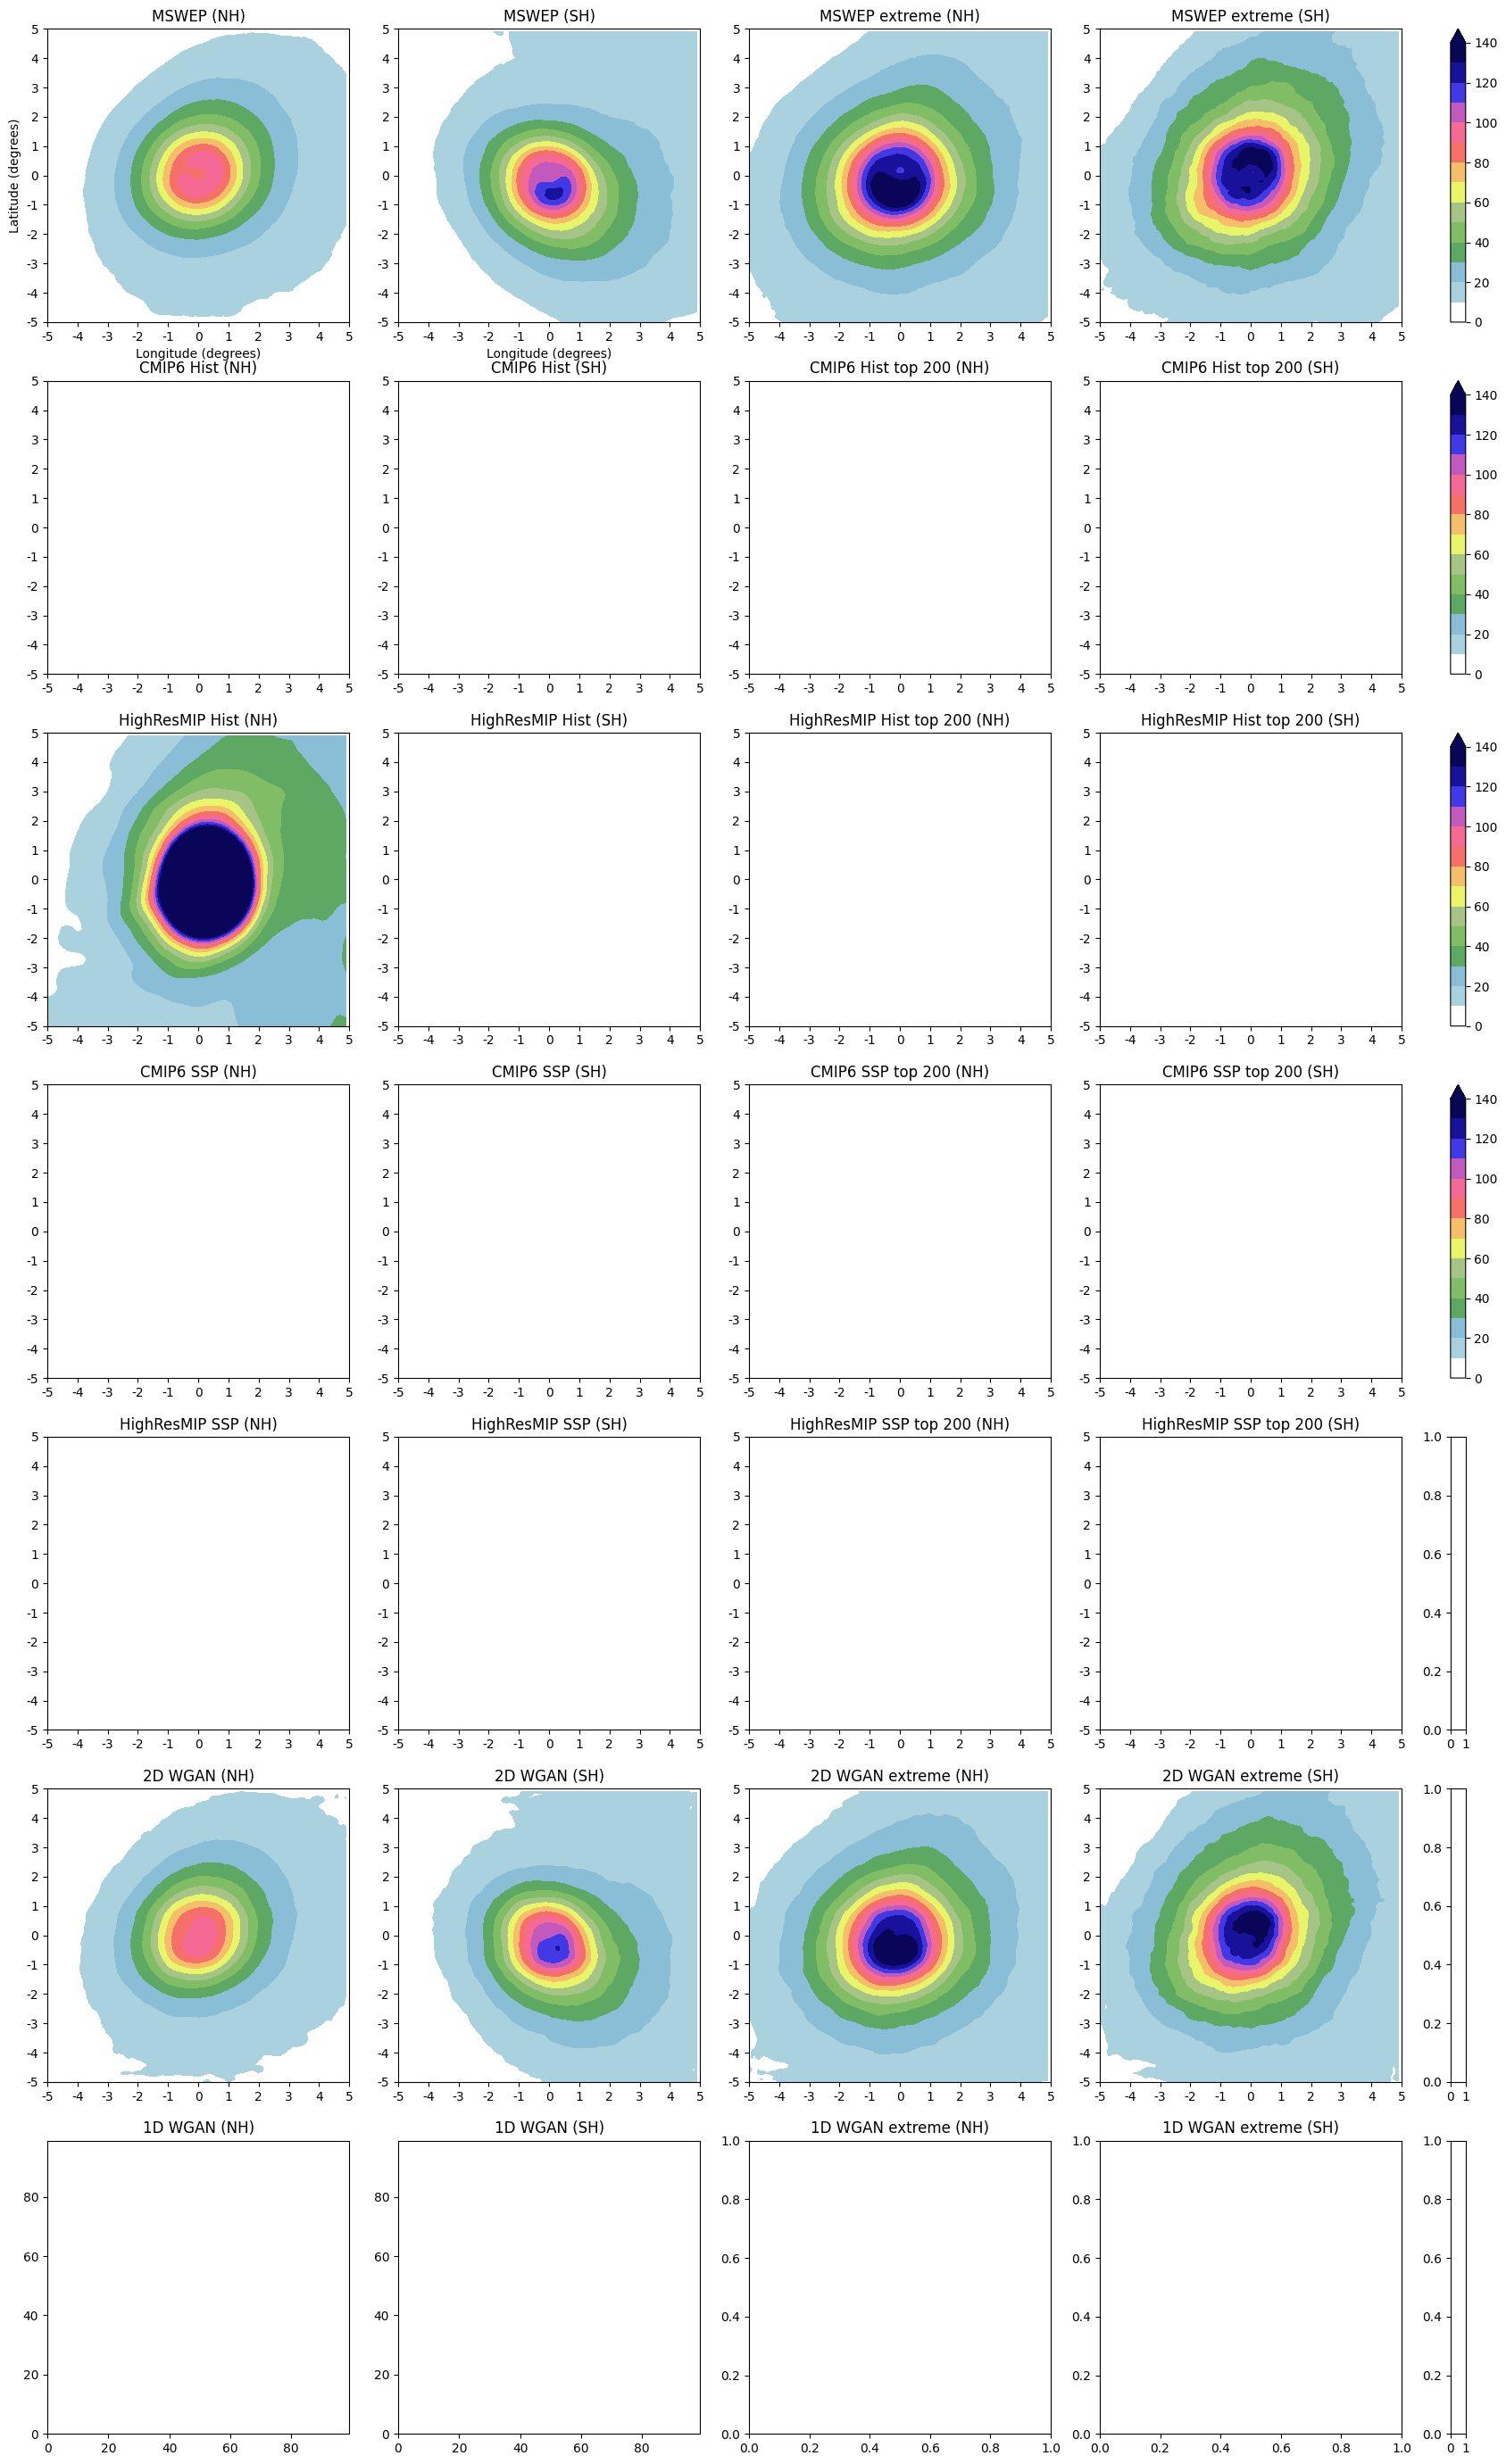

In [9]:

fig,axes = plt.subplots(7,5,figsize=(20.5, 35),gridspec_kw={'width_ratios': [1, 1, 1, 1, 0.05]})
im_1 = axes[0,0].contourf(composite_nh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_2 = axes[0,1].contourf(composite_sh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_3 = axes[0,2].contourf(composite_nh_x,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_4 = axes[0,3].contourf(composite_sh_x,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')

im_5 = axes[2,0].contourf(composite_hrmip_hist_nh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_6 = axes[2,1].contourf(composite_hrmip_hist_sh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')


im_pred_nh = axes[6,0].contourf(composite_wgan_nh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_pred_sh = axes[6,1].contourf(composite_wgan_sh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')


im_og_nh = axes[5,0].contourf(composite_og_nh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_og_sh = axes[5,1].contourf(composite_og_sh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_og_x_nh = axes[5,2].contourf(composite_og_x_nh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
im_og_x_sh = axes[5,3].contourf(composite_og_x_sh,cmap=precip_cmap,levels=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140],extend='max')
# Set the tick positions
t_p = [0,10,20,30,40,50,60,70,80,90,100]
t_l = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
for i in range(6):
	for j in range(4):
		axes[i,j].set_xticks(t_p)
		axes[i,j].set_yticks(t_p)
		# Set the tick labels
		axes[i,j].set_xticklabels(t_l)
		axes[i,j].set_yticklabels(t_l)
axes[0,0].set_title('MSWEP (NH)')
axes[0,0].set_xlabel('Longitude (degrees)')
axes[0,0].set_ylabel('Latitude (degrees)')
axes[0,1].set_title('MSWEP (SH)')
axes[0,1].set_xlabel('Longitude (degrees)')
# add **font to change font

axes[0,2].set_title('MSWEP extreme (NH)')
axes[0,3].set_title('MSWEP extreme (SH)')

axes[1,0].set_title('CMIP6 Hist (NH)')
axes[1,1].set_title('CMIP6 Hist (SH)')
axes[1,2].set_title('CMIP6 Hist top 200 (NH)')
axes[1,3].set_title('CMIP6 Hist top 200 (SH)')

axes[2,0].set_title('HighResMIP Hist (NH)')
axes[2,1].set_title('HighResMIP Hist (SH)')
axes[2,2].set_title('HighResMIP Hist top 200 (NH)')
axes[2,3].set_title('HighResMIP Hist top 200 (SH)')

axes[3,0].set_title('CMIP6 SSP (NH)')
axes[3,1].set_title('CMIP6 SSP (SH)')
axes[3,2].set_title('CMIP6 SSP top 200 (NH)')
axes[3,3].set_title('CMIP6 SSP top 200 (SH)')

axes[4,0].set_title('HighResMIP SSP (NH)')
axes[4,1].set_title('HighResMIP SSP (SH)')
axes[4,2].set_title('HighResMIP SSP top 200 (NH)')
axes[4,3].set_title('HighResMIP SSP top 200 (SH)')

axes[5,0].set_title('2D WGAN (NH)')
axes[5,1].set_title('2D WGAN (SH)')
axes[5,2].set_title('2D WGAN extreme (NH)')
axes[5,3].set_title('2D WGAN extreme (SH)')

axes[6,0].set_title('1D WGAN (NH)')
axes[6,1].set_title('1D WGAN (SH)')
axes[6,2].set_title('1D WGAN extreme (NH)')
axes[6,3].set_title('1D WGAN extreme (SH)')




plt.colorbar(im_2,ticks=[0,20,40,60,80,100,120,140],cax=axes[0,4])
plt.colorbar(im_5,ticks=[0,20,40,60,80,100,120,140],cax=axes[1,4])
plt.colorbar(im_5,ticks=[0,20,40,60,80,100,120,140],cax=axes[2,4])
plt.colorbar(im_5,ticks=[0,20,40,60,80,100,120,140],cax=axes[3,4])

plt.savefig('composite_rain.png',bbox_inches='tight')

In [ ]:
# method for composite rain plot:
# for each storm, sum up the rain along its track, centred on centre of TC.
# convert units from mm/3hr rainfall to mm/day rainfall. THis requires knowing if the storm timesteps are sampled every 3 hours or every 6 hours
# for 3 hourly storms you add up and divide by number of timesteps (storm duration/number of hours storm was alive for as a TC) to get mm/hr then multiply by 24
# for 6 hourly storms you add up rain at 6 hour points and interpolate to get values for 3 hourly points (otherwise you're only adding up half the rainfall). Then divide by number of timesteps and multiply by 24
# split into nh and sh
# do the mean for each hemisphere
